In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
def mae(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

1. Тесты

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

def plotProcess(n_samples=1000, beta=0):
    y = u = np.random.normal(size=n_samples)
    for t in range(n_samples):
        y[t] = beta * y[t-1] + u[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(y)
        p_adf = round(adfuller(y)[1], 3)
        p_kpss = round(kpss(y)[1], 3)
        plt.title(f"Beta: {beta}\n Dickey-Fuller p-value: {p_adf} \n KPSS p-value: {p_kpss}")

In [ ]:
for beta in [0, 0.6, 0.9, 1]:
    plotProcess(beta=beta)

# 2. Реальные данные

In [6]:
temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['T'] = temp_df['T'].ffill()
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
date_temp_df = temp_df.copy(deep=True)
date_temp_df['time'] = date_temp_df['time'].dt.date
date_temp_df = date_temp_df.groupby('time')['T'].mean()
date_temp_df = pd.DataFrame(date_temp_df)
date_temp_df.index = pd.date_range(start=date_temp_df.index[0], periods=len(date_temp_df.index), freq='D')

In [7]:
adfuller(date_temp_df)

(-5.558849677580517,
 1.5583829302800874e-06,
 13,
 6912,
 {'1%': -3.4312964308727882,
  '5%': -2.8619582455723314,
  '10%': -2.5669926282399707},
 30736.075353846674)

In [8]:
kpss(date_temp_df)

(0.014469182057071027,
 0.1,
 51,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [9]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

dtd_train, dtd_test = temporal_train_test_split(date_temp_df, test_size=100)
fh = ForecastingHorizon(dtd_test.index, is_relative=False)

In [49]:
import pmdarima as pm
from pmdarima import model_selection

arima_model = pm.ARIMA(order=(2,1,2), seasonal_order=(0,0,0,365))
arima_model.fit(date_temp_df)

ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 365))

In [ ]:
arima_model.summary()

In [41]:
len(dtd_train)

6826

In [47]:
dtd_pred = arima_model.predict_in_sample(start=6700)

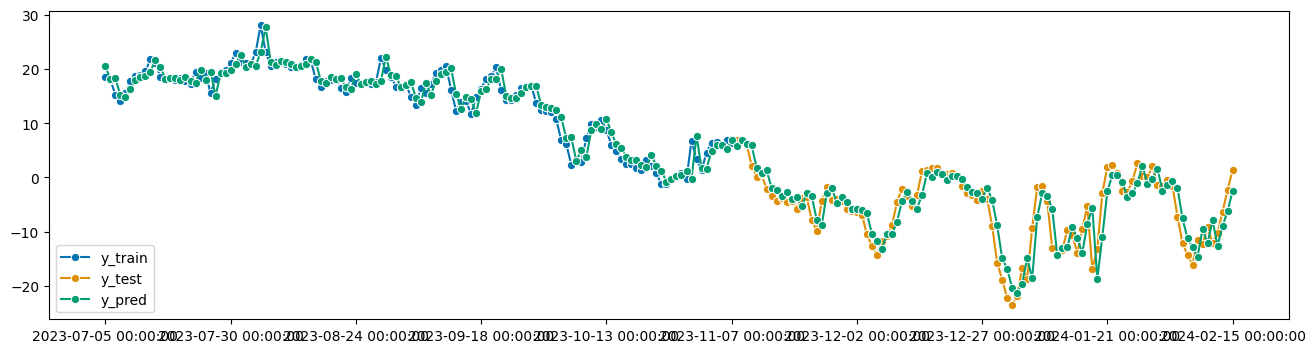

In [48]:
from sktime.utils.plotting import plot_series

fig, ax = plot_series(dtd_train[6700:], dtd_test, dtd_pred, labels=["y_train", "y_test", "y_pred"])
ax.legend(loc='lower left')
plt.show()